In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from PIL import Image

In [2]:
DATA_DIR = 'processed_videos/'
VIDEO_DIR = 'videos/'
SCORE_DIR = 'scores/'
MODEL_DIR = 'models/'

In [25]:
# Network architecture
class Net(torch.nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.backbone = models.mobilenet_v3_small(pretrained=True)
        for param in self.backbone.parameters():
            param.requires_grad = False
        #self.hidden = torch.nn.Linear(1000,100)
        self.classifiers = [torch.nn.Linear(1000,1) for _ in range(4)]
        self.classifiers = torch.nn.ModuleList(self.classifiers)
        
    def forward(self,x):
        sigmoid = torch.nn.Sigmoid()
        #x = sigmoid(self.hidden(self.backbone(x)))
        x = self.backbone(x)
        x1,x2,x3,x4 = [sigmoid(f(x)) for f in self.classifiers]
        x = torch.cat((x1,x2,x3,x4),dim=1)
        return x

In [26]:
# Read data from files
def read_filenames(filename):
    "Given the name of the information file, reads all video and label filenames."
    video_files,score_files = [],[]
    with open(DATA_DIR + filename) as f:
        for line in f:
            vf,sf = line.strip('\n').split(',')
            video_files.append(vf)
            score_files.append(sf)
    return video_files,score_files

# Generate labels
def generate_video_labels(vid_filename,score_filename, drop=20):
    """Given a video filename and its associated score filename, 
    returns the frame ids and scores downsampled by the drop factor."""
    cap = cv2.VideoCapture(DATA_DIR+VIDEO_DIR+vid_filename)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))-1
    frame_labels = [vid_filename+'_frame_'+str(i+1) for i in range(0,length,drop)]
    frame_scores = np.load(DATA_DIR+SCORE_DIR+score_filename)[:-1:drop,:]
    return frame_labels,frame_scores

# Generate dataset information
def generate_dataset_info(filename, drop=20):
    """Creates identifiers and scores for from the information file 
    downsapling videos by the drop factor."""
    video_files,score_files = read_filenames(filename)
    # Generate identifiers for each frame in the video files
    frame_ids,frame_scores = [],[]
    for v_fname,s_fname in zip(video_files,score_files):
        vf_id,vf_scores = generate_video_labels(v_fname,s_fname, drop)
        frame_ids += vf_id
        frame_scores += list(vf_scores)
        print("Video:",v_fname," - ",(len(vf_id),len(vf_scores)))
    return frame_ids, frame_scores

In [27]:
# DATASET LOADER FOR TORCH
# https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
class Dataset(torch.utils.data.Dataset):
  def __init__(self, list_IDs, labels):
        """Initializes the Dataset object with the list of frame identifiers 
        and the label dictionary."""
        self.labels = labels
        self.list_IDs = list_IDs
        # Normalization params for torchvision models
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        # Preprocessing layer
        self.preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)])

  def __len__(self):
        """Returns the total number of frames in the Dataset."""
        return len(self.list_IDs)

  def __getitem__(self, index):
        """Generates a processed frame with its associated scores."""
        # Select sample
        ID = self.list_IDs[index]
        # Extract video name from ID
        v_name,frame = ID.split('.')
        v_name += '.webm'
        frame = int(frame.split('_')[-1])
        # Load frame and label
        cap = cv2.VideoCapture(DATA_DIR+VIDEO_DIR+v_name)
        cap.set(1,frame)
        _,frame = cap.read()
        cap.release()
        frame=Image.fromarray(frame,'RGB')
        label = self.labels[ID]
        return self.preprocess(frame), torch.tensor(label).float()

In [28]:
# Model testing
def test_model(model, generator, use_cuda=False):
    """Returns the results of the model on the given generator for each dimension as a dictionary, 
    as well as the predictions, ground truth and average inference time."""
    model.eval()
    predicted,labels,inf_times = [],[],[]
    it = 1
    device = torch.device("cuda:0" if use_cuda else "cpu")
    with torch.set_grad_enabled(False):
        for local_batch, local_labels in generator:
            # Transfer to GPU and model computations
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)
            print('Testing batch %i/%i' % (it, len(generator)))
            if use_cuda:
                start = torch.cuda.Event(enable_timing=True)
                end = torch.cuda.Event(enable_timing=True)
                # Record inference time
                start.record()
                out = model(local_batch)
                end.record()
                # Sync
                torch.cuda.synchronize()
                inf_times.append(start.elapsed_time(end))
            else:
                # Record inference time
                start = time.time()
                out = model(local_batch)
                end = time.time()
                inf_times.append(end-start)
            predicted.append(out)
            labels.append(local_labels)
            it += 1
    pred,true=[],[]
    pred_np,true_np = [],[]
    if use_cuda:
        pred_np = [x.cpu().numpy() for x in predicted][:-1]
        true_np = [x.cpu().numpy() for x in labels][:-1]
    else:
        pred_np = predicted[:-1]
        true_np = labels[:-1]
    pred = np.stack(pred_np, axis=0).reshape(-1, 4)
    true = np.stack(true_np, axis=0).reshape(-1, 4)
    cols = ['Af','En','Ec','Le']
    scores_by_col = dict()
    for col in [0,1,2,3]:
        scores_by_col[cols[col]] = {"MSE": mean_squared_error(true[:,col], pred[:,col]),
        "MAE": mean_absolute_error(true[:,col], pred[:,col]),
        "MAPE": mean_absolute_percentage_error(true[:,col], pred[:,col]),
        "R2":r2_score(true[:,col], pred[:,col])}
    return pred,true,scores_by_col,sum(inf_times)/len(inf_times)

In [29]:
# Creating dataset info (train,test,validation)
train_ids, train_scores = generate_dataset_info('files_fulltrain.txt', drop=20)
#train_ids, train_scores = generate_dataset_info('files_train.txt', drop=20)
val_ids, val_scores = generate_dataset_info('files_validation.txt', drop=20)
test_ids, test_scores = generate_dataset_info('files_test.txt',drop=20)

# Partition initialization
partition = dict()
labels = dict()
partition['train'] = train_ids
partition['validation'] = val_ids
partition['test'] = test_ids
for x,y in zip(train_ids,train_scores):
    labels[x] = y
for x,y in zip(val_ids,val_scores):
    labels[x] = y
for x,y in zip(test_ids,test_scores):
    labels[x] = y

# Initializing data generators and datasets
params = {'batch_size': 256,
          'shuffle': True,
          'pin_memory': True,
          'num_workers': 0} 

train_dataset = Dataset(partition['train'], labels)
val_dataset = Dataset(val_ids,labels)
test_dataset = Dataset(test_ids,labels)

train_generator = torch.utils.data.DataLoader(train_dataset, **params)
val_generator = torch.utils.data.DataLoader(val_dataset, **params)
test_generator = torch.utils.data.DataLoader(test_dataset, **params)

Video: track1_11.webm  -  (571, 571)
Video: track1_1.webm  -  (581, 581)
Video: track1_4.webm  -  (585, 585)
Video: track1_5.webm  -  (486, 486)
Video: track1_7.webm  -  (577, 577)
Video: track2_11.webm  -  (794, 794)
Video: track2_1.webm  -  (803, 803)
Video: track2_4.webm  -  (801, 801)
Video: track2_5.webm  -  (671, 671)
Video: track2_7.webm  -  (800, 800)
Video: track3_11.webm  -  (424, 424)
Video: track3_1.webm  -  (432, 432)
Video: track3_4.webm  -  (440, 440)
Video: track3_5.webm  -  (359, 359)
Video: track3_7.webm  -  (426, 426)
Video: track1_2.webm  -  (574, 574)
Video: track2_2.webm  -  (781, 781)
Video: track3_2.webm  -  (426, 426)
Video: track1_2.webm  -  (574, 574)
Video: track2_2.webm  -  (781, 781)
Video: track3_2.webm  -  (426, 426)
Video: track1_6.webm  -  (592, 592)
Video: track2_6.webm  -  (799, 799)
Video: track3_6.webm  -  (409, 409)


In [30]:
# Enabling CUDA
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
print("USE_CUDA:",use_cuda)

USE_CUDA: True


In [31]:
# Training/Validation parameters
max_epochs = 1
model = Net()
if use_cuda:
    model = model.cuda()
criterion = torch.nn.L1Loss(reduce="sum")
optimizer = torch.optim.Adam(model.parameters(),lr=0.0005)

In [66]:
N_AVG = 16

train_history,val_history = [],[]
# Training and validating the network
for epoch in range(max_epochs):
    ############################ Training #############################
    model.train()
    total_loss,running_loss,it = 0.0,0.0,1
    for local_batch, local_labels in train_generator:
        # Transfer to GPU and model computations
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)   
        print('Training batch %i/%i' % (it, len(train_generator)))
        optimizer.zero_grad()
        out = model(local_batch)
        loss = criterion(out, local_labels)
        loss.backward()
        optimizer.step()
        running_loss += float(loss)
        total_loss += float(loss)
        it += 1
        if it % N_AVG == 0:
            print('<<Training>> [%d, %5d] loss: %.3f' % (epoch + 1, it + 1, running_loss / N_AVG))
            running_loss = 0.0
    print("<<Training>> Accumulated loss: %.3f Average loss: %.3f" % (total_loss, total_loss/len(train_generator)))
    train_history.append(total_loss/len(train_generator))
    ################################## Validation ####################
    continue
    model.eval()
    total_loss,running_loss,it = 0.0,0.0,0
    it = 1
    with torch.set_grad_enabled(False):
        for local_batch, local_labels in val_generator:
            # Transfer to GPU and model computations
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)
            print('Validation batch %i/%i' % (it, len(val_generator)))
            out = model(local_batch)
            loss = criterion(out, local_labels)
            running_loss += float(loss)
            total_loss += float(loss)
            it += 1
            if it % N_AVG == 0:
                print('<<Validation>> [%d, %5d] loss: %.3f' % (epoch + 1, it + 1, running_loss / N_AVG))
                running_loss = 0.0
    print("<<Validation>> Accumulated loss: %.3f Average loss: %.3f" % (total_loss, total_loss/len(val_generator)))
    val_history.append(total_loss/len(val_generator))
print('Training loss (epochwise):', train_history)
print('Validation loss (epochwise):', val_history)

USE_CUDA: True
Training batch 1/42
Training batch 2/42
Training batch 3/42
Training batch 4/42
Training batch 5/42
Training batch 6/42
Training batch 7/42
Training batch 8/42
Training batch 9/42
Training batch 10/42
Training batch 11/42
Training batch 12/42
Training batch 13/42
Training batch 14/42
Training batch 15/42
<<Training>> [1,    17] loss: 0.152
Training batch 16/42
Training batch 17/42
Training batch 18/42
Training batch 19/42
Training batch 20/42
Training batch 21/42
Training batch 22/42
Training batch 23/42
Training batch 24/42
Training batch 25/42
Training batch 26/42
Training batch 27/42
Training batch 28/42
Training batch 29/42
Training batch 30/42
Training batch 31/42
<<Training>> [1,    33] loss: 0.138
Training batch 32/42
Training batch 33/42
Training batch 34/42
Training batch 35/42
Training batch 36/42
Training batch 37/42
Training batch 38/42
Training batch 39/42
Training batch 40/42
Training batch 41/42
Training batch 42/42
<<Training>> Accumulated loss: 5.992 Ave

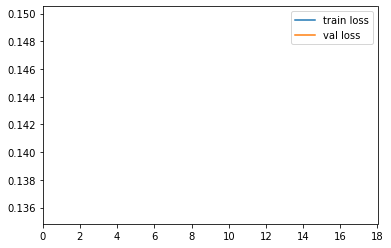

In [67]:
plt.plot(train_history, label="train loss")
plt.plot(val_history, label="val loss")
plt.legend()
plt.xlim(0,max_epochs)
plt.show()

In [69]:
# Model saving
filename = 'weights_9'
if use_cuda:
    torch.save(model.cpu().state_dict(), MODEL_DIR + filename)
else:
    torch.save(model.state_dict(), MODEL_DIR + filename)

In [32]:
# Model loading
if use_cuda:
    model.load_state_dict(torch.load("models/weights_6"))
    model = model.cuda()
else:
    model.load_state_dict(torch.load("models/model_weights",map_location=lambda storage, loc: storage))

In [ ]:
# Model testing
pred_test,gt_test,test_scores,inf_time = test_model(model,test_generator, use_cuda=True)
print(test_scores)
print("Average inference time:", inf_time)